In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import os
import torchsnooper
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
num_epochs = 5
batch_size = 100
learning_rate = 0.0001

train_set  = torch.Tensor(np.load("/project/projectdirs/majorana/users/stew314/train_set.npy"))
train_labels = torch.Tensor(np.load("/project/projectdirs/majorana/users/stew314/train_labels.npy"))
train_dataset = torch.utils.data.TensorDataset(train_set,train_labels)
train_loader  = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_set = torch.Tensor(np.load("/project/projectdirs/majorana/users/stew314/test_set.npy"))
test_labels = torch.Tensor(np.load("/project/projectdirs/majorana/users/stew314/test_labels.npy"))
test_dataset = torch.utils.data.TensorDataset(test_set,test_labels)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

In [3]:
# define class for CNN, define initializer and forward
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2))
        self.layer2  = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2))
        self.layer3  = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2))
        self.layer4 = nn.Sequential(
            nn.Conv1d(64, 512, kernel_size=5, padding=2),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(2))
        self.layer5 = nn.Sequential(
            nn.Conv1d(512, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2))
        self.fc1 = nn.Linear(16128, 128)
        self.fc2 = nn.Linear(128,256)
        self.fc3 = nn.Linear(256,64)
        self.fc4 = nn.Linear(64,64)
        self.fc5 = nn.Linear(64,1)
    
    #@torchsnooper.snoop()
    # defines how an input tensor flows thru the network
    def forward(self, x):
        x = x.unsqueeze(1)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)
        out = torch.sigmoid(out)
        return out
    
cnn = CNN()

In [ ]:
criterion = nn.BCELoss() # Loss
optimizer = torch.optim.RMSprop(CNN.parameters(cnn),lr=learning_rate)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels).view(-1,1)

        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data))

In [ ]:
sigmoid_d = []
sigmoid_db = []
testY = []
predY = []

for images, labels in test_loader:
    cnn.eval()
    with torch.no_grad():
        outputs  = cnn(images)
        lb_data = labels.cpu().data.numpy().flatten()
        output_data = outputs.cpu().data.numpy().flatten()
        signal = np.argwhere(lb_data == 1.0)
        bkg = np.argwhere(lb_data == 0.0)
        sigmoid_d += list(output_data[signal].flatten())
        sigmoid_db += list(output_data[bkg].flatten())
        testY += list(lb_data)
        predY += list(output_data)
testY = np.array(testY)
predY = np.array(predY)
# pred_result = np.zeros(predY.shape)
# pred_result[predY]
auc = roc_auc_score(testY, predY)
print(auc)
fpr, tpr, thr = roc_curve(testY, predY)
effindex = np.abs(tpr-0.75).argmin()
effpurity = 1.-fpr[effindex]
print(effpurity)
plt.hist(sigmoid_d,histtype="step")
plt.hist(sigmoid_db,histtype="step")
plt.show()

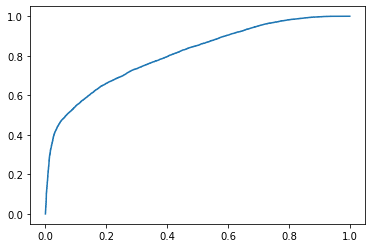

In [10]:
plt.plot(fpr, tpr, label = 'AUC = ' + str(auc))